In [65]:
from typing import Union
import scanpy as sc
import anndata
import logging
import os
import numpy as np
import pandas as pd
import json
import sys
# import scanpy.external as sce
logging.basicConfig(level=logging.INFO)
import tqdm

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.neighbors import kneighbors_graph
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression

from scipy import stats
import pingouin

import matplotlib.pyplot as plt
import seaborn as sns

import umap

# from PySpots.fish_helpers import *
from dredFISH.Analysis import basicu
from dredFISH.Analysis import powerplots
from dredFISH.Analysis import regu
from dredFISH.Analysis import celltypeu
from dredFISH.Analysis import evalu
from dredFISH.Analysis import TissueGraph as tgh

import importlib
importlib.reload(tgh)
importlib.reload(celltypeu)
importlib.reload(evalu)
importlib.reload(basicu)
sc.set_figure_params(figsize=(7, 7))

In [2]:
logging.info('hi')

INFO:root:hi


In [3]:
def anova_eta2(ydata, ylabels):
    """ydata = (nsample, nvariable)
    ylabel = (nsample,)
    """
    gmean = ydata.mean(axis=0)

    SSt = np.power((ydata-gmean), 2).sum(axis=0)
    SSb = np.zeros(ydata.shape[1])

    clsts = np.unique(ylabels)
    # Yclsts = []
    for clst in clsts:
        cond = ylabels==clst
        yclst = ydata[cond]
        lmean = yclst.mean(axis=0)
        ln = len(yclst)

        # for each gene
        SSb += np.power((lmean-gmean), 2)*ln

    # get eta2
    assert np.all(SSb<=SSt)
    eta2 = SSb/(SSt+1e-6)
    return eta2, SSt, SSb

# file paths and load data

In [4]:
prj_dir = '/bigstore/GeneralStorage/fangming/projects/dredfish/'
dat_dir = prj_dir + 'data/'
res_dir = prj_dir + 'data_dump/'
fig_dir = prj_dir + 'figures/'

# allen data
scrna_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_DPNMF_matrix.h5ad'
# scrna_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_10x_ctxhippo_a_DPNMF_matrix.h5ad'

scrna_genes_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_DPNMF_genes_matrix.h5ad'

# DPNMF matrix 
pmat_path = f'{dat_dir}dpnmf.csv' 


In [5]:
%%time
# allen scrna matrix
ref_data = anndata.read_h5ad(scrna_path)
# print(ref_data)
ref_data_genes = anndata.read_h5ad(scrna_genes_path) # library size normed (no log)




CPU times: user 772 ms, sys: 1.3 s, total: 2.07 s
Wall time: 3.2 s


In [6]:
pmat = pd.read_csv(pmat_path, index_col=0).loc[ref_data_genes.var.index]
pmatf = (pmat/pmat.sum(axis=0))
print(pmat.shape)
print(pmatf.shape)
pmat_maxw = pmat.max(axis=1)
pmatf_maxw = pmatf.max(axis=1)

(5576, 24)
(5576, 24)


In [7]:
# prepare
ref_data.obs = ref_data.obs.rename(columns={
    'class_label': 'Level_1_class_label', 
    'neighborhood_label': 'Level_2_neighborhood_label', 
    'subclass_label': 'Level_3_subclass_label', 
    # 'supertype_label', 
    'cluster_label': 'Level_5_cluster_label', 
})

celltype_levels = np.sort(ref_data.obs.filter(regex=r'^Level_[0-9]', axis=1).columns.values)
print(celltype_levels)

levels = celltype_levels[:3]      
X_refdata = np.array(ref_data.X)

['Level_1_class_label' 'Level_2_neighborhood_label'
 'Level_3_subclass_label' 'Level_5_cluster_label']


In [8]:
# ref_data.obs.groupby('Level_1_class_label').size()
print(ref_data)
print(ref_data_genes)

AnnData object with n_obs × n_vars = 73347 × 24
    obs: 'donor_sex_id', 'donor_sex_label', 'donor_sex_color', 'region_id', 'region_label', 'region_color', 'platform_label', 'cluster_order', 'Level_5_cluster_label', 'cluster_color', 'subclass_order', 'Level_3_subclass_label', 'subclass_color', 'neighborhood_id', 'Level_2_neighborhood_label', 'neighborhood_color', 'class_order', 'Level_1_class_label', 'class_color', 'exp_component_name', 'external_donor_name_label', 'full_genotype_label', 'facs_population_plan_label', 'injection_roi_label', 'injection_materials_label', 'injection_method_label', 'injection_type_label', 'full_genotype_id', 'full_genotype_color', 'external_donor_name_id', 'external_donor_name_color', 'facs_population_plan_id', 'facs_population_plan_color', 'injection_materials_id', 'injection_materials_color', 'injection_method_id', 'injection_method_color', 'injection_roi_id', 'injection_roi_color', 'injection_type_id', 'injection_type_color', 'cell_type_accession_label',

# Run gene reconstruction
- find neighbors using 24 bits
- reconstruct genes in high-dimensions based on those neighbors

- what gene set to use: 5818 genes involved (5576 overlap with scRNA SS)

In [9]:
%%time
# randomly split cells into train (lowdim, highdim) and test (lowdim, highdim to be predicted)
X = ref_data.X.copy()
yraw = np.array(ref_data_genes.X.todense()).copy()

X = basicu.zscore(X, axis=0)
y = np.log10(yraw+1)
# y.data = np.log10(y.data+1)

print(X.shape, y.shape)

(73347, 24) (73347, 5576)
CPU times: user 7.22 s, sys: 5.26 s, total: 12.5 s
Wall time: 12.5 s


In [10]:
# eta results -- used below; naming is bad for historical reasons
eta2_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_DPNMF_genes_eta2.h5ad'
adata = anndata.read_h5ad(eta2_path)
adata

AnnData object with n_obs × n_vars = 73347 × 5576
    obs: 'donor_sex_id', 'donor_sex_label', 'donor_sex_color', 'region_id', 'region_label', 'region_color', 'platform_label', 'cluster_order', 'Level_5_cluster_label', 'cluster_color', 'subclass_order', 'Level_3_subclass_label', 'subclass_color', 'neighborhood_id', 'Level_2_neighborhood_label', 'neighborhood_color', 'class_order', 'Level_1_class_label', 'class_color', 'exp_component_name', 'external_donor_name_label', 'full_genotype_label', 'facs_population_plan_label', 'injection_roi_label', 'injection_materials_label', 'injection_method_label', 'injection_type_label', 'full_genotype_id', 'full_genotype_color', 'external_donor_name_id', 'external_donor_name_color', 'facs_population_plan_id', 'facs_population_plan_color', 'injection_materials_id', 'injection_materials_color', 'injection_method_id', 'injection_method_color', 'injection_roi_id', 'injection_roi_color', 'injection_type_id', 'injection_type_color', 'cell_type_accession_label

# use LASSO regression?

In [11]:
def get_r2(y, yhat):
    """
    """
    r2 = 1-np.power(y-yhat, 2).sum()/np.power(y-np.mean(y), 2).sum()
    return r2

def get_mse(y, yhat):
    """
    """
    mse = np.power(y-yhat, 2).mean()
    return mse
    
def get_pearsonr(y, yhat):
    """
    """
    r, p = stats.pearsonr(y, yhat)
    return r

In [69]:
def regression_pipe(X, y, alpha=0, n_splits=3):
    """LASSO linear regression.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    # build model
    if alpha < 1e-6:
        model = LinearRegression()
    else:
        model = Lasso(alpha=alpha, random_state=0)
    
    ygs = np.empty(len(y))
    yps = np.empty(len(y))
    
    mse_s = []
    l0s = []
    l1s = []
    
    for train_idx, test_idx, in tqdm.tqdm(kf.split(X)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # train
        model.fit(X_train, y_train)
        # test
        yhat = model.predict(X_test)
        # evaluation and record
        ygs[test_idx] = y_test
        yps[test_idx] = yhat
        
        l0 = (np.abs(model.coef_) > 1e-6).sum() 
        l1 = np.abs(model.coef_).sum()
        l0s.append(l0)
        l1s.append(l1)
    
    return ygs, yps, l0s, l1s

def tuning_regression(X, y, alphas, n_splits=3):
    """
    """
    res = []
    ressum = []
    for alpha in alphas:
        print(alpha)
        # run
        ygs, yps, l0s, l1s = regression_pipe(X, y, alpha, n_splits=n_splits)
        res.append((ygs, yps, l0s, l1s))
        ressum.append({
           'Reg Strength': alpha,
           'MSE': get_mse(ygs, yps),
           'r2': get_r2(ygs, yps),
           'coef L0': np.mean(l0s),
           'coef L1': np.mean(l1s),
          })
    
    ressum = pd.DataFrame(ressum)
    return res, ressum

def plot_regression_pipe(ax, ygs, ypgs, clusters, title="", legend=True):
    """
    """
    r2 = get_r2(ygs, yps)
    dfplot = pd.DataFrame()
    dfplot['Ground truth'] = ygs
    dfplot['Prediction'] = yps
    dfplot['Cluster'] = clusters 
    sns.scatterplot(data=dfplot, 
                    x='Ground truth',
                    y='Prediction',
                    hue='Cluster',
                    hue_order=np.sort(dfplot['Cluster'].unique()),
                    edgecolor='none',
                    s=5,
                    ax=ax,
                   )

    scale = min(max(ygs), max(yps))
    ax.plot([0, scale], [0, scale], color='k', linestyle='--')
    ax.set_title(f"{title}")
    ax.text(1, 0.1, f'r2={r2:.2f}', ha='right', transform=ax.transAxes)
    sns.despine(ax=ax)
    if legend:
        ax.legend(bbox_to_anchor=(1,1))
    else:
        ax.get_legend().remove()
    
def plot_ressum_reg(ressum, evalcol='AUPR', scale='linear', title=''):
    """
    """
    fig, axs = plt.subplots(2, 1, figsize=(5, 8), sharex=True)
    ax = axs[0]
    ax.plot(ressum['Reg Strength'], ressum['coef L0'], '-o')
    ax.set_ylabel('# genes used')
    ax.grid()
    sns.despine(ax=ax)
    ax.set_xscale(scale)
    ax.set_title(title)
    
    ax = axs[1]
    ax.plot(ressum['Reg Strength'], ressum[evalcol], '-o')
    ax.set_ylabel(evalcol)
    ax.set_xlabel('Regularization')
    # ax.set_ylim(ymax=1.02)
    ax.grid()
    sns.despine(ax=ax)
    ax.set_xscale(scale)
    if scale == 'linear':
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-4,-4))
    
    plt.show()

In [13]:
# predict 1 gene using other genes
y.shape

(73347, 5576)

In [38]:
%%time
genes = ref_data_genes.var.index.values 
clusterlabels = ref_data_genes.obs['subclass_label'].values

idx = np.arange(y.shape[1])
trgt_idx = 1000
ftr_idx = idx[idx!=trgt_idx]
thegene = genes[trgt_idx]
print(thegene)


_X = y[:,ftr_idx]
_y = y[:,trgt_idx]
ygs, yps, l0s, l1s = regression_pipe(_X, _y, alpha=0, n_splits=3)
print(get_r2(ygs, yps), get_mse(ygs, yps))

Chpf


3it [02:34, 51.66s/it]

0.23528454255602993 0.4357332170111542
CPU times: user 30min 24s, sys: 3min 20s, total: 33min 44s
Wall time: 2min 43s


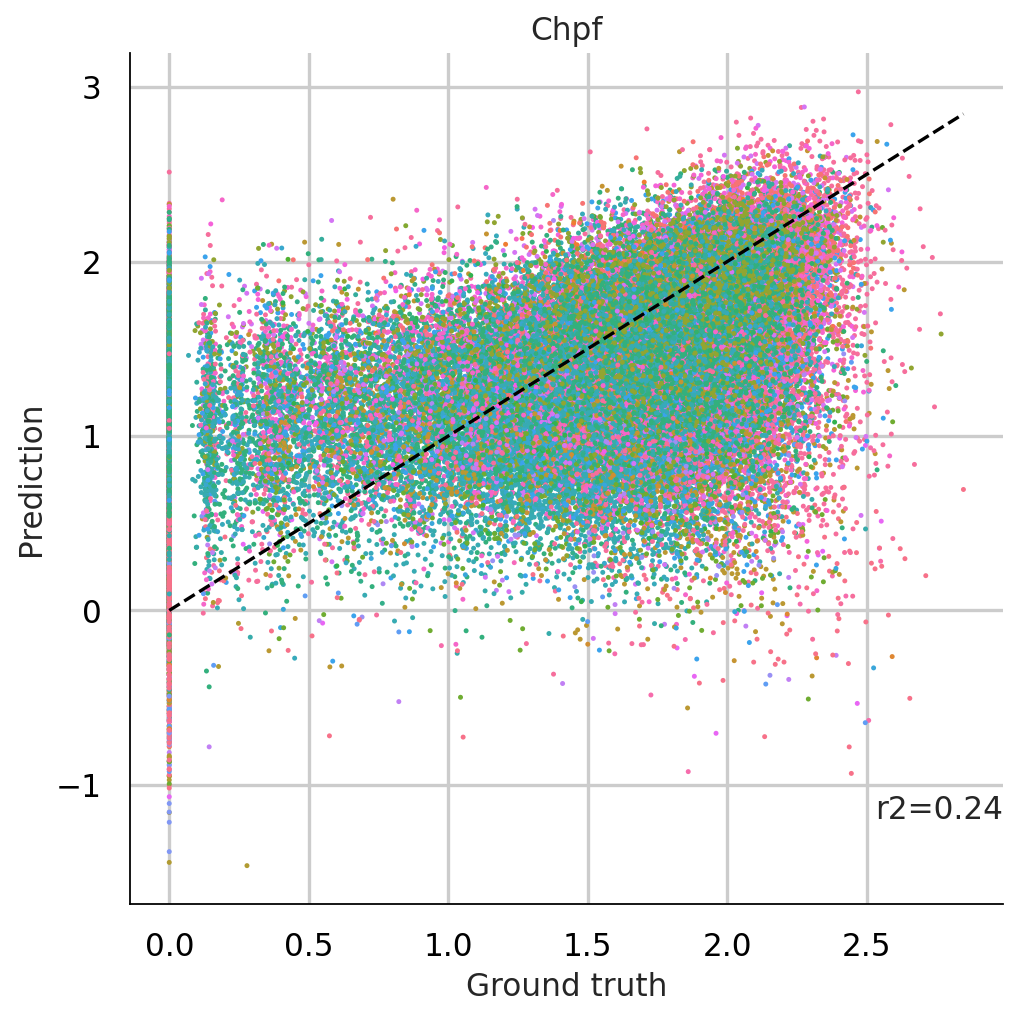

In [39]:
fig, ax = plt.subplots()
plot_regression_pipe(ax, ygs, yps, clusters, title=thegene, legend=False)
plt.show()

In [ ]:
%%time
# alphas = np.logspace(-3,-1,3)
# alphas = [2e-3, 3e-3, 4e-3, 5e-3, 6e-3, 7e-3, 8e-3, 10e-3]

alphas = np.linspace(1e-3, 1e-2, 10)
print(alphas)

res, res_sum = tuning_regression(_X, _y, alphas, n_splits=2)

output = os.path.join(res_dir, 'lasso_reg_chpf_May4.csv') 
print(output)
res_sum.to_csv(output)

[0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.01 ]
0.001


0it [00:00, ?it/s]/home/fangming/anaconda3/envs/routine/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.955e+02, tolerance: 2.080e+00

1it [02:54, 174.99s/it]/home/fangming/anaconda3/envs/routine/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.074e+02, tolerance: 2.099e+00

2it [06:02, 181.17s/it]


0.002


0it [00:00, ?it/s]/home/fangming/anaconda3/envs/routine/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.852e+02, tolerance: 2.080e+00

1it [02:27, 147.78s/it]/home/fangming/anaconda3/envs/routine/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.685e+02, tolerance: 2.099e+00

2it [04:59, 149.91s/it]


0.003


0it [00:00, ?it/s]/home/fangming/anaconda3/envs/routine/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.356e+01, tolerance: 2.080e+00

1it [02:11, 131.21s/it]/home/fangming/anaconda3/envs/routine/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.183e+02, tolerance: 2.099e+00

2it [04:24, 132.41s/it]


0.004


0it [00:00, ?it/s]

In [ ]:
plot_ressum_reg(res_sum, evalcol='r2', scale='log', title='')

# Check a low-dim residual 

In [ ]:
importlib.reload(basicu)

# remove cluster centroids

y_cntrids_exp = basicu.group_mean(y, ref_data_genes.obs['subclass_label'], expand=True)
yr = y - y_cntrids_exp

In [ ]:
yr.shape

In [ ]:
np.random.seed(0)
pca = PCA(n_components=100)
pcs = pca.fit_transform(yr)
pcs.shape

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.cumsum(pca.explained_variance_ratio_), '-o')
ax.set_ylim(ymin=0)
ax.set_ylabel('Cumulative explained variance')
ax.set_xlabel('Num of PCs')
ax.set_title('Residual PCA (removed cluster centroids)')
plt.show()